### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ipynb
import importlib

In [59]:
import ipynb.fs.full.modules.Environment as Environment
import ipynb.fs.full.modules.Bees as Bees
import ipynb.fs.full.modules.Utils as Utils
import ipynb.fs.full.modules.Config as config
import ipynb.fs.full.modules.BeeKeeper as BeeKeeper

# RUN

In [89]:
importlib.reload(Environment)
importlib.reload(Bees)
importlib.reload(Utils)
importlib.reload(config)
importlib.reload(BeeKeeper)

<module 'ipynb.fs.full.modules.BeeKeeper' (/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/ipynb/modules/BeeKeeper.ipynb)>

In [90]:
config.RANDOM_SEED, config.WORKER_THRESHOLD, config.ENABLE_PROBABILISTIC

(70, 0.01, True)

In [91]:
def create_bees():
    bees = []
    for bee_i in range(config.NUM_WORKERS):
        bee_params = config.BEE_PARAMS
        bee_params["num"] = bee_i
        bee = Bees.Worker(bee_params)
        bees.append(bee)
    return bees

In [93]:
np.random.seed(config.RANDOM_SEED)

# Setup directory
Utils.setup_directories(config.SAVE_FOLDER)

# CREATE CLASS OBJECTS
# ------------------------------------------------------------
environment = Environment.Environment(config.ENVIRONMENT_PARAMS)
queen_bee = Bees.Queen(config.QUEEN_PARAMS)
bees = create_bees()
bee_keeper = BeeKeeper.BeeKeeper(config.BEE_KEEPER_PARAMS)
# ------------------------------------------------------------

# Cleanup previous pngs
for old_file_path in glob2.glob(f"{config.SAVE_FOLDER}/t*.png"):
    os.remove(old_file_path)

# ============================================================
try:
    for global_i, t_i in enumerate(environment):
        num_srcs = len(environment.pheromone_sources)
        sys.stdout.write(f"\rTimestep: {global_i+1}/{environment.t_grid.shape[0]} -- Num srcs: {num_srcs}")
        sys.stdout.flush()

        # Step 1: Check for and build sources list for current timestep
        # ----------------------------------------------------
        # Update pheromone list from queen bee
        environment.update_pheromone_sources(queen_bee, t_i)
        
        environment.cull_pheromone_sources(t_i)
        
        # Update pheromone list from worker bees
        for bee_i, bee in enumerate(bees):
            environment.update_pheromone_sources(bee, t_i)
        # ----------------------------------------------------
    
#         sys.stdout.write(f"\rNum Srcs: {len(environment.pheromone_sources)}")
#         sys.stdout.flush()
        # Step 2: Build Concentration map and get gradients
        # ----------------------------------------------------
        # Init concentration map for current timestep to 0's
        # environment.init_concentration_map()
        # Iterate through pheromone sources and build concentration maps
        # -- for each pheromone source, calculate gradient for each bee
        for pheromone_src in environment.pheromone_sources:
            # Update concentration map with x, y, A, dt, etc.
            pheromone_src_C = environment.update_concentration_map(t_i, pheromone_src)   
            
            # Iterate through list of active bees and calculate gradient
            for bee in bees:
                bee.sense_environment(t_i, environment, pheromone_src, pheromone_src_C)
        # ----------------------------------------------------

        # Step 3: Update bees & environment
        # ----------------------------------------------------
        queen_bee.update()

        for bee_i, bee in enumerate(bees):
            bee.update()
            
            # Measure and store bee info
            bee_keeper.measure_bees(bee, queen_bee, global_i)

        # Store concentration maps
        bee_keeper.measure_environment(environment)
        # ----------------------------------------------------

        # Take steps (update movement, clear grads, etc)
        queen_bee.step()
        for bee in bees:
            bee.step(environment)
    
    bee_keeper.log_data_to_handy_dandy_notebook()
    
except KeyboardInterrupt:
    print("\nEnding early.")
    bee_keeper.log_data_to_handy_dandy_notebook()
    

Creating concentration map...
Creating timecourse...
Timestep: 129/300 -- Num srcs: 35
Ending early.


Text(0,0.5,'Concentration')

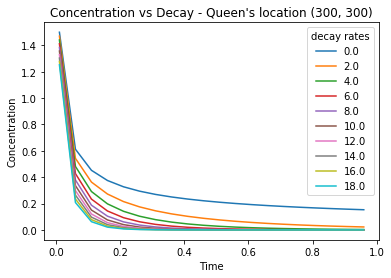

In [76]:
def diffusion_eq(A, D, x, x_source, y, y_source, wb, wx, wy, t, decay_rate):
    term_1 = A / np.sqrt(t)
    dx = x - x_source
    dy = y - y_source

    term_2 = (dx - wb*wx * t)**2 + (dy - wb*wy * t)**2
    denom = ((4 * D * t)) 
    c = term_1 * (np.exp(-(term_2 / denom) - (decay_rate * t)))
    return c 

A = 0.15
D = 0.6
x, y = 0.0, 0.0
x_source, y_source = 0, 0
wb = 0
wx, wy = 0, 0 
t_array = np.arange(0.01, 1, 0.05)
decay_rate = np.arange(0.0, 19.0, 2)

for decay in decay_rate:
    C = []
    for t in t_array:
        c = diffusion_eq(A, D, x, x_source, y, y_source, wb, wx, wy, t, decay_rate=decay)
        C.append(c)
    plt.plot(t_array, C, label=str(decay))
plt.legend(loc='upper right', title="decay rates")
plt.title("Concentration vs Decay - Queen's location (300, 300)")
# plt.title("Concentration vs Decay - Queen's vicinity (340, 340)")
plt.xlabel("Time")
plt.ylabel("Concentration")